In [ ]:
import matplotlib.pyplot as plt
import cv2
import re
import os
import numpy as np
import pandas as pd
import json
import collections
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils import plot_model
from keras.models import Model
from keras.preprocessing import image
from time import time
import pickle
from keras.layers import Dense, Input, Embedding, LSTM, Dropout
from keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pickle import dump, load
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
from keras.models import load_model

In [2]:
def readFile (path):
    with open(path, encoding="utf8") as file:
        data = file.read()
    return data


In [3]:
data = readFile(r"C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/caption_dataset.txt")

captions = data.split('\n')

captions = captions[:-1]

In [4]:
print("Total captions: " + str(len(captions)))

Total captions: 158914


In [5]:
print(captions[30])

1000919630.jpg#0	A man sits in a chair while holding a large stuffed animal of a lion .


In [6]:
content = {}

for line in captions:
    imageID, caption = line.split('\t')

    imageID = imageID.split('.')[0]

    if content.get(imageID) is None:
        content[imageID] = []
    
    content[imageID].append(caption)

In [7]:
print(content[captions[30].split('.')[0]])

['A man sits in a chair while holding a large stuffed animal of a lion .', 'A man is sitting on a chair holding a large stuffed animal .', 'A man completes the finishing touches on a stuffed lion .', 'A man holds a large stuffed lion toy .', 'A man is smiling at a stuffed lion']


In [8]:
img_path = r"C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/flickr30k_images"
imageID = captions[30].split('.')[0]
for caption in content[imageID]:
    print(caption)

A man sits in a chair while holding a large stuffed animal of a lion .
A man is sitting on a chair holding a large stuffed animal .
A man completes the finishing touches on a stuffed lion .
A man holds a large stuffed lion toy .
A man is smiling at a stuffed lion


In [9]:
def cleaning_data(data):
    data = data.lower()
    
    data = re.sub("[^a-z]+", " ", data)

    return data

In [10]:
print(cleaning_data("A man sits in a chair while holding a large stuffed animal of a lion."))

a man sits in a chair while holding a large stuffed animal of a lion 


In [11]:
for img_id, caption_lst in content.items():
    for i in range(len(caption_lst)):
        content[img_id][i] = cleaning_data(content[img_id][i])

In [12]:
print(content[captions[30].split('.')[0]][-1])

a man is smiling at a stuffed lion


In [13]:
with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/tokens.txt","w") as file:
    file.write(str(content))

In [14]:
caption_dir = "C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/caption_dataset.txt" 
images_dir = "C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/flickr30k_images"
images_file = os.listdir(images_dir)
print("Number of images: " + format(len(images_file)))

Number of images: 31783


In [15]:
file = open(caption_dir, 'r', encoding='utf8')
text = file.read()
datatext = []

for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    key = col[0].split('#')
    datatext.append(key + [col[1].lower()])
dataset_flickr = pd.DataFrame(datatext, columns = ["filename","index","caption"])
filenames = np.unique(dataset_flickr.filename.values)
print("Number of files = " + format(len(filenames)))

Number of files = 31783


In [16]:
def to_vocab(dataset_flickr):
    vocabulary = []
    for i in range(len(dataset_flickr)):
        temp_val = dataset_flickr.iloc[i,2]
        vocabulary.extend(temp_val.split())
    print("Vocabulary size = %d"  %len(set(vocabulary)))

In [17]:
vocabulary_size = to_vocab(dataset_flickr)

Vocabulary size = 20324


In [18]:
content = None

with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/tokens.txt",'r') as file:
    content = file.read()

json_string = content.replace("'", "\"")
content = json.loads(json_string)

In [19]:
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)
print ("Total Number of words: %d" %len(total_words) )


Total Number of words: 1955230


In [20]:
counter = collections.Counter(total_words)

frequency_count = dict(counter)

len(frequency_count.keys())

18079

In [21]:
sorted_frequency_count = sorted(frequency_count.items(), reverse=True, key=lambda x:x[1])
threshold = 10
sorted_frequency_count = [x for x in sorted_frequency_count if x[1]>threshold]

total_words = [x[0] for x in sorted_frequency_count]
len(total_words)

5136

In [22]:
training_data = ""
testing_data = ""

with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/images_testdataset.txt",'r') as file:
    testing_data = file.read()

with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/images_traindataset.txt",'r')as file:
    training_data = file.read()

In [23]:
train_data = [img_file for img_file in training_data.split("\n")[:-1]]
test_data = [img_file for img_file in testing_data.split("\n")[:-1]]

train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [24]:
training_content = {}
for imageid in train_data:
    training_content[imageid] = []
    for caption in content[imageid]:
        caption_append = "startseq " + caption +" endseq"
        training_content[imageid].append(caption_append)

In [25]:
training_content['1001633352']

['startseq three young men and a young woman wearing sneakers are leaping in midair at the top of a flight of concrete stairs  endseq',
 'startseq four casually dressed guys jumping down a stairway outdoors with a stone wall behind them  endseq',
 'startseq four guys three wearing hats one not are jumping at the top of a staircase  endseq',
 'startseq four men with excited faces are jumping down from the top of stairs  endseq',
 'startseq four people are jumping from the top of a flight of stairs  endseq']

In [26]:
model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

In [27]:
# model.summary()

In [28]:
my_model = Model(model.input, model.layers[-2].output)

In [29]:
def image_preprocess(img): 
    img = load_img(img, target_size = (224,224))
    img = img_to_array(img)

    img = np.expand_dims(img,axis = 0)

    img = preprocess_input(img)

    return img


In [30]:
def encode_image(img):
    img = image_preprocess(img)
    features = my_model.predict(img)

    features = features.reshape((-1,))
    return features

In [ ]:
training_vector = {}

# start_time = time()

for index, imageID in  enumerate(train_data):
    image_path = "C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/flickr30k_images/" + imageID + ".jpg"

    training_vector[imageID] = encode_image(image_path)

    if index%100 == 0:
        print("Encoding in progress... STEP", index)


# # end_time = time()


In [32]:
with open("train_features.pkl","wb") as file:
    pickle.dump(training_vector, file)
    

In [ ]:
training_vector = load(open("/content/drive/MyDrive/Flickr30k_Dataset/dataset/train_features.pkl", "rb"))

In [ ]:
testing_vector = {}

for index, imageID in enumerate(test_data):
    image_path = "C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/flickr30k_images/" + imageID + ".jpg"

    testing_vector[imageID] = encode_image(image_path)

    if index%100 == 0:
        print("Encoding in progress ... STEP", index)


In [34]:
with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/test_features.pkl", "wb") as file:
    pickle.dump(testing_vector, file)

In [35]:
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [36]:
print(len(index_to_word))

5136


In [37]:
print(index_to_word[5])
print(word_to_index['is'])

and
7


In [38]:
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

vocab_size = len(word_to_index) + 1

In [39]:
print(vocab_size)

5139


In [40]:
with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/word_to_index.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/index_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)


In [41]:
max_len = 0

for cap_list in training_content.keys():
    for caption in training_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [42]:
print(max_len)

80


In [43]:
file = open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/glove.6B.50d.txt", encoding = 'utf8')

In [44]:
embeddings_index = {}

for line in file:
    values = line.split()

    word = values[0]

    coefs = np.array(values[1:], dtype = 'float')

    embeddings_index[word] = coefs


file.close()



In [45]:
embedding_dim = 50

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [46]:
embedding_matrix.shape

(5139, 50)

In [47]:
input_features = Input(shape = (2048,))
in1 = Dropout(0.3)(input_features)
in2 = Dense(256, activation='relu')(in1)

inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [48]:
decoder1 = add([in2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model (inputs=[input_features, inp_cap], outputs=outs)

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 50)       256950      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [50]:
plot_model(model, to_file='dataset/model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer = 'adam')


In [52]:
def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i]
                    yi = idx_seq[i] 
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] 
                    yi = to_categorical([yi], num_classes=vocab_size)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0

In [53]:
epochs = 15
batch_size = 5
steps = len(training_content)//batch_size

In [ ]:
for i in range(epochs):
    generator = data_generator(training_content, training_vector, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/models/model_' + str(i) + '.h5')

In [ ]:
# model.load_weights('./model_checkpoints/model_14.h5')

In [ ]:
from pickle import dump, load
with open("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/test_features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def generate(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
images = 'C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/flickr30k_images'

In [ ]:
z = 0
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate(image))
print(pic)

In [ ]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        caption_append = caption
        test_content[imageID].append(caption_append)

In [ ]:
x = 0
pic = list(encoding_test.keys())[x]
test_content[pic]

In [ ]:
x = 3
pic = list(encoding_test.keys())[x]
test_content[pic]


reference = test_content[pic]
print(pic)
e = encoding_test[pic].reshape(1,2048)
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
caption = generate(e)
print("Caption:",caption)
print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))

In [5]:
max_len = 80

In [6]:
word_to_index = {}
with open ("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/word_to_index.pkl", 'rb') as file:
    word_to_index = pd.read_pickle(file, compression=None)

index_to_word = {}
with open ("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/index_to_word.pkl", 'rb') as file:
    index_to_word = pd.read_pickle(file, compression=None)

    
model = load_model('C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/dataset/models/model_14.h5')

resnet50_model = ResNet50 (weights = 'imagenet', input_shape = (224, 224, 3))
resnet50_model = Model (resnet50_model.input, resnet50_model.layers[-2].output)
def predict_caption(photo):
    inp_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_index[w] for w in inp_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=80, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]

        inp_text += (' ' + word)

        if word == 'endseq':
            break

    final_caption = inp_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

def preprocess_image (img):
    img = load_img(img, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def encode_image (img):
    img = preprocess_image(img)
    feature_vector = resnet50_model.predict(img)
    # feature_vector = feature_vector.reshape((-1,))
    return feature_vector


def runModel(img_name):
    #img_name = input("enter the image name to generate:\t")
    photo = encode_image(img_name).reshape((1, 2048))
    caption = predict_caption(photo)
    img_data = plt.imread(img_name)
    plt.imshow(img_data)
    print(caption)

1/1 [==============================] - 0s 27ms/step
a man is sitting on a bench with his legs crossed


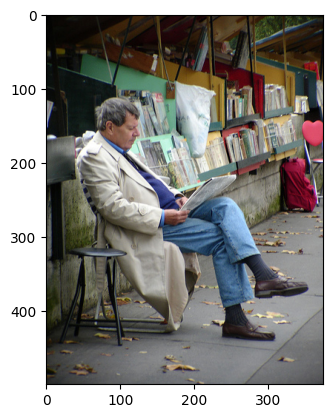

In [50]:
# runModel("C:/Users/Acer/Documents/Image Caption Generator/Image-Caption-Generator/Flickr30k_Dataset/testimages/test1.jpg")